<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/8_support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVMs)

Machine learning models used for linear or nonlinear classification and regression.

SVMs are usually good with small to medium-sized nonlinear datasets (instance counts from hundreds to thousands) and do not scale well with large datasets.

In [238]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [239]:
# helper function(s)

# Plot Supper Vector Classifier Decision Boundary
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
  w = svm_clf.coef_[0]
  b = svm_clf.intercept_[0]

  # At the decision boundary, w0*x0 + w1*x1 + b = 0
  # => x1 = -w0/w1 * x0 - b/w1

  x0 = np.linspace(xmin, xmax, 200)
  decision_boundary = -w[0] / w[1] * x0 - b / w[1]

  margin = 1/w[1]
  gutter_up = decision_boundary + margin
  gutter_down = decision_boundary - margin
  svs = svm_clf.support_vectors_

  plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
  plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
  plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
  plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors="#AAA", zorder=-1)

# Linear SVM Classification

The basic concept of SVM classifiers can be clarified by an example and some figures.

We will consider a linearly separable  binary classification problem based on the Iris dataset. 

The classes we consider are "Setosa" and "Versicolor" (because they are linearly separable). And we only use the "Petal Length" and  "Petal Width" features so we can plot some figures.

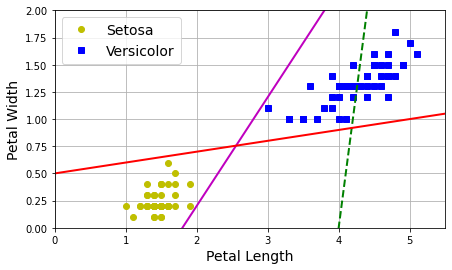

In [240]:
# Load the Iris dataset
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

# keep the setosa and versicolor classes only (1 is versicolor)
setosa_or_versicolor = (y == 0) | (y == 1)
X_setosa_versicolor = X[setosa_or_versicolor]
y_setosa_versicolor = y[setosa_or_versicolor]

# fit some bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

# plot data
plt.figure(figsize=(7, 4))
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 0],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 0],
         "yo", label="Setosa")
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 1],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 1],
         "bs", label="Versicolor")
plt.legend(loc="upper left")
plt.grid()
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")

# plot decision boundaries
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.show()

The figure shows 3 potential classifiers:
  * The dashed green line is so bad that it cannot even separate the classes.
  * The magenta and red classifiers are fine; however, they probably won't generalize well because their decision boundaries are too close to instances from each of the classes.

Let's check what a linear SVM classifier can generate:


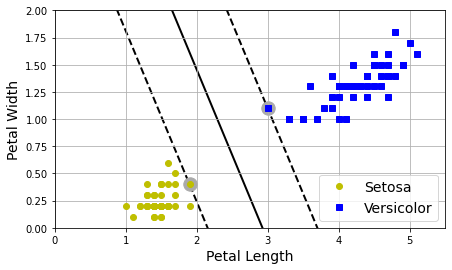

In [241]:
# Train and plot a linear SVM classifier
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X_setosa_versicolor, y_setosa_versicolor)

# plot the decision boundary and the support vectors
plt.figure(figsize=(7, 4))
plot_svc_decision_boundary(svm_clf, 0, 5.5)

# plot data
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 0],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 0],
         "yo", label="Setosa")
plt.plot(X_setosa_versicolor[:, 0][y_setosa_versicolor == 1],
         X_setosa_versicolor[:, 1][y_setosa_versicolor == 1],
         "bs", label="Versicolor")
plt.legend(loc="lower right")
plt.grid()
plt.axis([0, 5.5, 0, 2])
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()


One can think of fitting an SVM classifier as fitting the widest possible street (parallel dashed lines above) between the classes. 

The decision boundary (solid line) stays as far away from the closest training instances as possible. This is why it is sometimes called _large margin classification_

Adding more training instances "off the street" will not affect the decision boundary because it is fully determined (or "supported") by instances located on the edge of the street (the support vectors) and they are highlighted in the figure above.

----------- 
**NOTE**: SVMs are sensitive to the feature scales. When the features are unscaled (in this example the vertical scale is larger than the horizontal scale) the widest street will be close horizontal. Feature scaling will improve generalization and will probably generate a wider street.

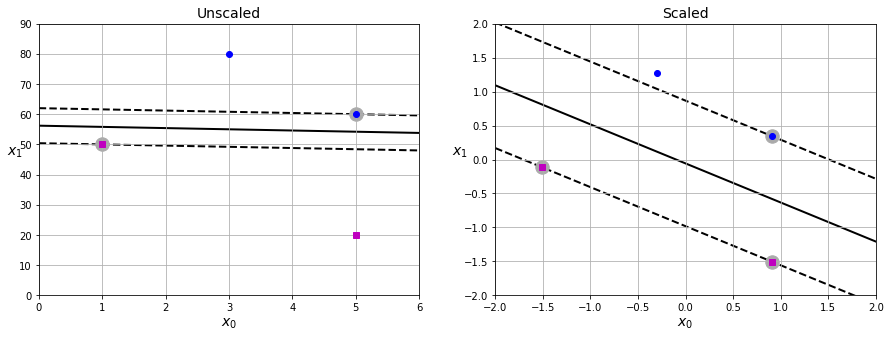

In [242]:
from sklearn.preprocessing import StandardScaler

# Generate artifical dataset where x0, x1 are on different scale
Xs = np.array([
    [1, 50],
    [5, 20],
    [3, 80],
    [5, 60]
]).astype(np.float64)

ys = np.array([
    0,
    0,
    1,
    1
])

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)


# Train two SVC on the unscaled and scaled dataset
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

# plot the unscaled data and resulting decision boundary
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(Xs[:, 0][ys == 0], Xs[:, 1][ys == 0], "ms")
plt.plot(Xs[:, 0][ys == 1], Xs[:, 1][ys == 1], "bo")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$", rotation=0)
plt.title("Unscaled")
plt.grid()
plt.axis([0, 6, 0, 90])
plot_svc_decision_boundary(svm_clf, 0, 6)

# plot the scaled data and resulting decision boundary
plt.subplot(122)
plt.plot(X_scaled[:, 0][ys == 0], X_scaled[:, 1][ys == 0], "ms")
plt.plot(X_scaled[:, 0][ys == 1], X_scaled[:, 1][ys == 1], "bo")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$", rotation=0)
plt.title("Scaled")
plt.grid()
plt.axis([-2, 2, -2, 2])
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)

plt.show()

## Soft Margin Classification

When all instances are strictly forced to be "off the street" and on the correct side we get _hard margin classification_ (used in the notebook thusfar). It comes with a couple of issues:
1. It only works if the data is linearly separable
2. It is sensitive to outliers (the street will be less wide and will not generalize well because of a single outlier)

The solution to these issues is to allow some _margin violations_ (instances in the middle of the street or on the wrong side) and this is called _soft margin classification_. The objective is to find a good balance between keeping the street as wide as possible and limiting _margin violations_

In `sklearn` the regularization hyperparameter `C` allows you to control the amount of margin violations. 
* Low `C` results in wider street and allows more margin violations
* Large `C` results in narrower street and less marging violations

If the SVC model is underfitting or overfitting you can use `C` to control the bias/variance trade-off.

In [243]:
# generate 2 additional instances of the Setosa class
X_outliers = np.array([
    [3.4, 1.3],
    [3.2, 0.9]
])
y_outliers = np.array([
    0,
    0
])

# Not linearly separable dataset (Hard margin SVC does not work)
Xo1 = np.concatenate([X_setosa_versicolor, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y_setosa_versicolor, y_outliers[:1]], axis=0)

# Dataset with a single outlier
Xo2 = np.concatenate([X_setosa_versicolor, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y_setosa_versicolor, y_outliers[1:]], axis=0)

Not linearly separable data

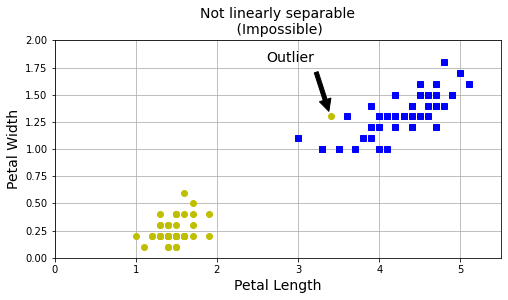

In [244]:
plt.figure(figsize=(8, 4))
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(X_outliers[0][0] - 0.5, X_outliers[0][1] + 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.grid()
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Not linearly separable\n (Impossible)")
plt.axis([0, 5.5, 0, 2])
plt.show()

In [245]:
svm_clf_impossible = SVC(kernel="linear", C=float("inf"), max_iter=1000).fit(Xo1, yo1)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Effect of an outlier

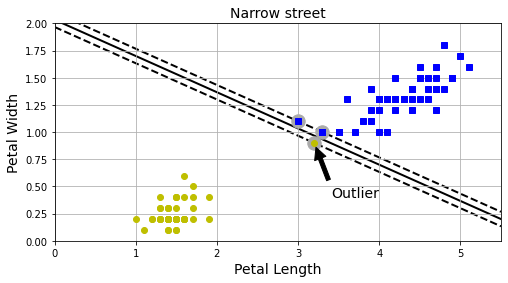

In [246]:
plt.figure(figsize=(8, 4))
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(X_outliers[1][0] + 0.5, X_outliers[1][1] - 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.grid()
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Narrow street")
plt.axis([0, 5.5, 0, 2])

# fit an SVC
svm_clf_outlier = SVC(kernel="linear", C=float("inf")).fit(Xo2, yo2)
plot_svc_decision_boundary(svm_clf_outlier, 0, 5.5)
plt.show()

Effect of the `C` regularization hyperparameter

The Virginica class is not linearly separable, so we use it to show the effect of changing `C`

In [247]:
# Binary classification probelm (Virginica/Not Virginica)

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

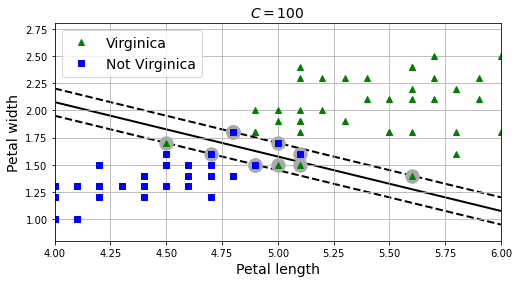

In [248]:
# Lower C allows more margin violation and wider street (less variance)
# Higher C allows less margin violation and narrower street (more variance)

#C = 1e-1
#C = 1
C = 100

svm_clf = SVC(kernel="linear", C=C)
svm_clf.fit(X, y)

plt.figure(figsize=(8, 4))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Not Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf.C}$")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()
plt.show()

In [249]:
# Testing a new instance
X_new = [
    [5.5, 1.7],
    [5.0, 1.5]
]
svm_clf.predict(X_new)

array([ True, False])

In [250]:
svm_clf.decision_function(X_new)

array([ 2.99651419, -0.59993491])

# Nonlinear SVM Classfication

Linear SVM are linear classifiers; however, we can use them to tackle nonlinear datasets using different techniques:

* Polynomial Features
* Polynomial Kernel
* Similarity Features
* Gaussian RBF Kernel


In [251]:
# helper functions

def plot_dataset(X, y, axes):
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
  plt.axis(axes)
  plt.grid(True)
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
  x1s = np.linspace(axes[0], axes[1], 100)
  x2s = np.linspace(axes[2], axes[3], 100)
  x1, x2 = np.meshgrid(x1s, x2s)
  X = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X).reshape(x1.shape)
  y_decision = clf.decision_function(X).reshape(x1.shape)
  plt.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)
  plt.contourf(x1, x2, y_decision, cmap=plt.cm.brg, alpha=0.1)


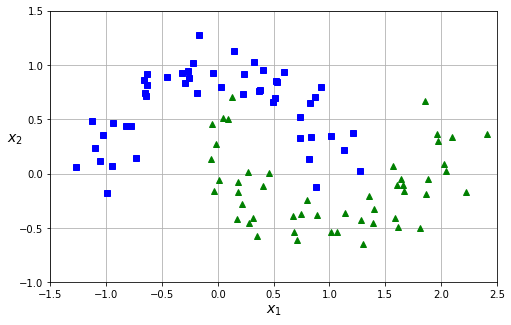

In [252]:
# Make two interleaving half circles

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.figure(figsize=(8, 5))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Polynomial Features

Using `PolynomialFeatures` will add features of any polynomial `degree`. However, the added feature might make the model too slow.

The following shows a simple example (9 instances total/2 classes) of 1 dimensional and not linearly separable dataset. Adding a second feature $x_2 = x_1^2$ makes the resulting 2 dimensional data linearly separable

X1 	| y
------	|----
[-4.] 	| 0
[-3.] 	| 0
[-2.] 	| 1
[-1.] 	| 1
[0.] 	| 1
[1.] 	| 1
[2.] 	| 1
[3.] 	| 0
[4.] 	| 0



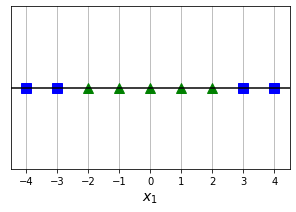

In [253]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y1D = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

print("X1 \t| y")
print("------\t|----")
for i, j in zip(X1D, y1D):
  print(f"{i} \t| {j}")

print()

plt.figure(figsize=(5, 3))
plt.plot(X1D[:, 0][y1D==0], np.zeros(4), "bs", markersize=10)
plt.plot(X1D[:, 0][y1D==1], np.zeros(5), "g^", markersize=10)
plt.gca().get_yaxis().set_ticks([])
plt.grid()
plt.axhline(y=0, color="k")
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])
plt.show()

X1 	 X2 	| y
------	------ 	|----
-4.0 	 16.0 	| 0
-3.0 	 9.0 	| 0
-2.0 	 4.0 	| 1
-1.0 	 1.0 	| 1
0.0 	 0.0 	| 1
1.0 	 1.0 	| 1
2.0 	 4.0 	| 1
3.0 	 9.0 	| 0
4.0 	 16.0 	| 0



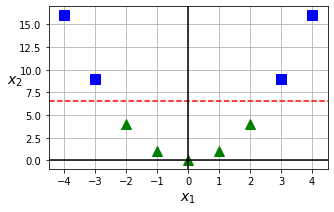

In [254]:
X2D = np.c_[X1D, X1D**2]

print("X1 \t X2 \t| y")
print("------\t------ \t|----")
for i, j in zip(X2D, y1D):
  print(f"{i[0]} \t {i[1]} \t| {j}")

print()

plt.figure(figsize=(5, 3))
plt.plot(X2D[:, 0][y1D==0], X2D[:, 1][y1D==0], "bs", markersize=10)
plt.plot(X2D[:, 0][y1D==1], X2D[:, 1][y1D==1], "g^", markersize=10)
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--")
plt.grid()
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-4.5, 4.5, -1, 17])
plt.show()

We now apply the same concept to the moons dataset, adding 3rd degree polynomials then scaling the features before training a linear SVM classifier

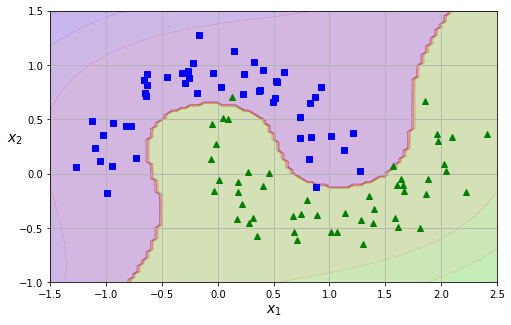

In [255]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    SVC(kernel="linear", C=10, max_iter=10000, random_state=42)
)

polynomial_svm_clf.fit(X, y)

plt.figure(figsize=(8, 5))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.show()

## Polynomial Kernel

Kernel tricks are mathematical techniques that allows us to get the same result of adding many polynomial features without actually having to add any feature. This means the number of features will not increase and the model will not be slower (compared to the linear case)

The kernel can be set using `kernel` in the `SVC` class. For `kernel=poly` we can choose the desired polynomial degree using `degree`, and `coef0` controls how much the model is influenced by high-degree terms versus low-degree terms

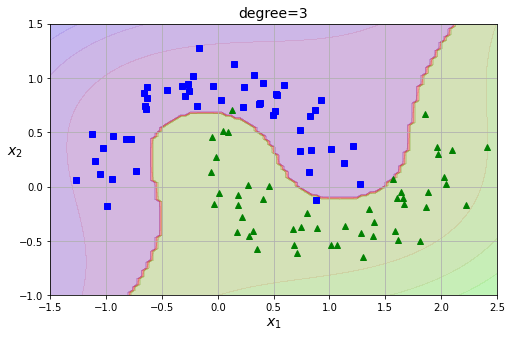

In [256]:
degree = 3
#degree = 15
#degree = 100

poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=degree, coef0=1, C=5, max_iter=10000, random_state=42)
)

poly_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(8, 5))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.title(f"degree={degree}")
plt.show()

## Similarity Features

We can handle nonlinear datasets by adding features computed using a similarity function instead of higher polynomial degrees. A similarity function measures how each instance in the dataset resembles a particular landmark. A landmark can be any instance (or instances) in the dataset itself. 

A commonly used similarity function is the Gaussian Radial Basis Function (Gaussian RBF):

$$
k(a, b) = e^{-\gamma ||a - b||^2 }
$$

$\gamma$ controls the amount of desired similarity. Larger values result in narrower bell-shaped curve (inverse of $\sigma$)

There are different approaches for selecting landmark, but the simplest is to create a landmark at each and every instance in the dataset. Of course if you have $m$ instances you will be generating $m$ features (assuming you will drop the original features). This method have an increased chance of making the training set linearly separable.

In [257]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

The following plot shows the values generated by the Gaussian RBF for 2 landmarks (highlighted in red). The largest similarity value is 1 at the corresponding landmark and the similarity gets smaller as we move away from the landmark. $\gamma$ controls the width of the Gaussian bell curve.

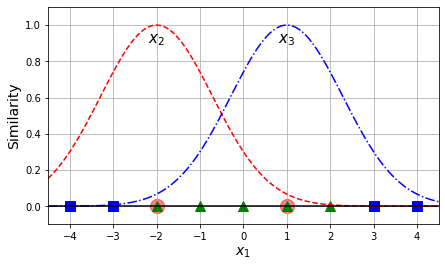

In [258]:
gamma = 0.3
#gamma = 10

landmark1 = X1D[2]
landmark2 = X1D[5]

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, landmark1, gamma)
x3s = gaussian_rbf(x1s, landmark2, gamma)

plt.figure(figsize=(7, 4))
plt.plot(X1D[:, 0][y1D==0], np.zeros(4), "bs", markersize=10)
plt.plot(X1D[:, 0][y1D==1], np.zeros(5), "g^", markersize=10)
plt.scatter(x=[landmark1, landmark2], y=[0, 0], s=200, alpha=0.5, c="red")
plt.text(landmark1, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(landmark2, 0.9, "$x_3$", ha="center", fontsize=15)
plt.plot(x1s, x2s, "r--")
plt.plot(x1s, x3s, "b-.")
plt.grid()
plt.axhline(y=0, color="k")
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.axis([-4.5, 4.5, -0.1, 1.1])
plt.show()

We can transform the original dataset and drop the original features.

Landmark1: [-2.]
Landmark2: [1.]

X2 	 X3 	| y
------	------ 	|----
0.30 	 0.00 	| 0
0.74 	 0.01 	| 0
1.00 	 0.07 	| 1
0.74 	 0.30 	| 1
0.30 	 0.74 	| 1
0.07 	 1.00 	| 1
0.01 	 0.74 	| 1
0.00 	 0.30 	| 0
0.00 	 0.07 	| 0



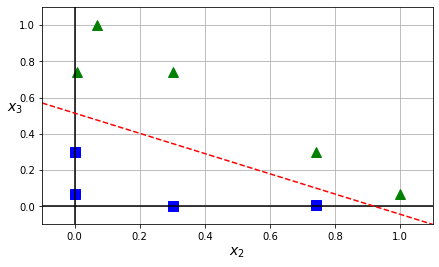

In [259]:
gamma = 0.3

landmark1 = X1D[2]
landmark2 = X1D[5]

print("Landmark1:", landmark1)
print("Landmark2:", landmark2)
print()

# compute the new features
XK = np.c_[gaussian_rbf(X1D, landmark1, gamma), gaussian_rbf(X1D, landmark2, gamma)]

print("X2 \t X3 \t| y")
print("------\t------ \t|----")
for i, j in zip(XK, y1D):
  print("{:.2f} \t {:.2f} \t| {:d}".format(i[0], i[1], j))

print()

plt.figure(figsize=(7, 4))
plt.plot(XK[:, 0][y1D==0], XK[:, 1][y1D==0], "bs", markersize=10)
plt.plot(XK[:, 0][y1D==1], XK[:, 1][y1D==1], "g^", markersize=10)
plt.grid()
plt.axhline(y=0, color="k")
plt.axvline(x=0, color="k")
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$", rotation=0)
plt.axis([-0.1, 1.1, -0.1, 1.1])
plt.show()

## Gaussian RBF Kernel

Similar to the Polynomial Kernel trick, we can use the similarity function technique (i.e. Gaussian RBF) without actually having to generate new features. All we need to do is to use a Gaussian RBF Kernel.

`SVC` models with `kernel="rbf"` have 2 hyperparameters that can be used for regularization:

* `gamma`
  * Increasing `gamma` makes the bell curve narrower and the effect of each instance is therefore smaller. The decision boundary is more irregular and tries to classify each instance correctly (higher variance)
  * Decreasing `gamma` makes the bell curve wider and the effect of each instance is larger. The decision boundary is smoother. (lower variance)
* `C` is regularization hyperparameter
   * Increasing `C` reduces regularization
   * Decreasing `C` increases regularization

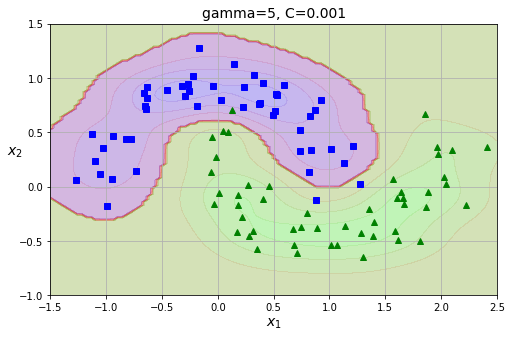

In [260]:

gamma = 5
#gamma = 35

C = 0.001
#C = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=gamma, C=C)
)

rbf_kernel_svm_clf.fit(X, y)


plt.figure(figsize=(8, 5))
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plt.title(f"gamma={gamma}, C={C}")
plt.show()

# `SVC` vs `LinearSVC` Time Complexity

So far we only used the `SVC` class, which is based on the `libsvm` library. We used it with different kernels (i.e. `linear`, `poly`, `rbf`). The training time complexity is between $\mathcal{O}(m^2 \times n)$ and $\mathcal{O}(m^3 \times n)$ which doesn't scale with larger datasets (i.e. large $m$)

`sklearn` provides an alternative class `LinearSVC` that doesn't accept any kernels and is only used in the linear case. This class is based on the `liblinear` library and its training time complexity is about $\mathcal{O}(m \times n)$ which is faster than `SVC` with `kernel=linear`

If you plan on using a linear SVM with a large training set, you should plan on using `LinearSVC`

# SVM Regression

When we used SVM for classification we tried to fit the largest possible street between two classes while limiting margin violations. If we change the objective a bit we can use SVM for regression.

For SVM regression we try to fit as many instances as possible _on_ the street while limiting margin violations (instances off the street). The width of the street in this case is controlled by a hyperparameter $\epsilon$.

Decreasing $\epsilon$ (narrower street) increases the number of support vectors (instances off the street or on the edge) which in turn helps regularize the model. 

`SVR` for regression is equivalent to `SVC` for classification (they both accept a kernel).

`LinearSVR` for regression is equivalent to `LinearSVC` for classification (they dont' accept a kernel and they are faster than `SVR`/`SVC` with `kernel="linear"`)

In [261]:
# helper functions

# Find the original unscaled values of the support vectors
def find_suppor_vectors(svm_reg, X, y):
  y_pred = svm_reg.predict(X)
  epsilon = svm_reg[-1].epsilon
  off_margin = np.abs(y - y_pred) >= epsilon
  return np.argwhere(off_margin)


# plot SVM regression
def plot_svm_regression(svm_reg, X, y, axes, plot_epsilon=False):
  x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
  y_pred = svm_reg.predict(x1s)
  epsilon = svm_reg[-1].epsilon
  plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
  plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
  plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
  plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
              facecolor='#AAA', zorder=-1)
  plt.plot(X, y, "bo")
  if (plot_epsilon):
    xt = x1s[50].reshape(-1, 1)
    yt = svm_reg.predict(xt)
    plt.annotate(
        '', xy=(xt, yt), xycoords='data',
        xytext=(xt, yt - epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
    plt.text(xt - 0.1, yt - epsilon,r"$\epsilon$", fontsize=16)
  plt.title(f"$\epsilon={epsilon}$")
  plt.legend(loc="upper left")
  plt.grid()
  plt.axis(axes)

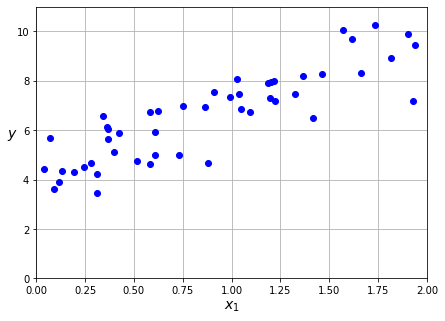

In [262]:
# generate linear regression data

w0 = 4
w1 = 3

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = w0 + w1 * X[:, 0] + np.random.randn(50)

plt.figure(figsize=(7, 5))
plt.plot(X, y, "bo")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 11])
plt.grid()
plt.show()

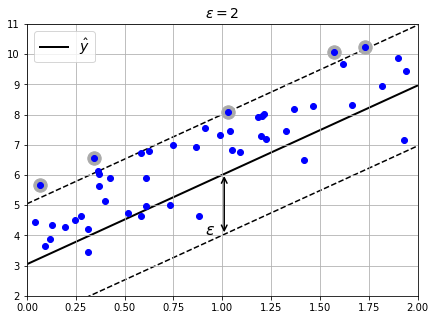

In [263]:
from sklearn.svm import LinearSVR

epsilon=2
#epsilon=0.4

svm_reg = make_pipeline(
    StandardScaler(),
    LinearSVR(epsilon=epsilon, random_state=42)
)

svm_reg.fit(X, y)

svm_reg._support = find_suppor_vectors(svm_reg, X, y)
plt.figure(figsize=(7, 5))
plot_svm_regression(svm_reg, X, y, [0, 2, 2, 11], plot_epsilon=True)

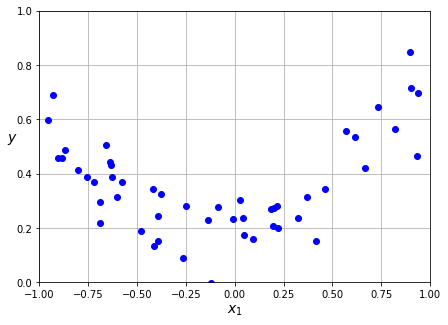

In [264]:
# generate non-linear quadratic regression data

w0 = 0.2
w1 = 0.1
w2 = 0.5

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = w0 + w1 * X[:, 0] + w2 * X[:, 0] ** 2 + np.random.randn(50) / 10

plt.figure(figsize=(7, 5))
plt.plot(X, y, "bo")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-1, 1, 0, 1])
plt.grid()
plt.show()

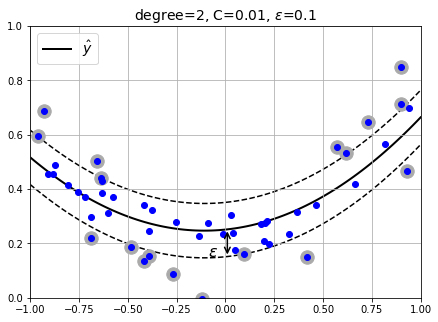

In [265]:
from sklearn.svm import SVR

degree = 2
C = 0.01
epsilon = 0.1

svm_poly_reg = make_pipeline(
    StandardScaler(),
    SVR(kernel="poly", degree=degree, C=C, epsilon=epsilon)
)

svm_poly_reg.fit(X, y)
svm_poly_reg._support = find_suppor_vectors(svm_poly_reg, X, y)
plt.figure(figsize=(7, 5))
plot_svm_regression(svm_poly_reg, X, y, [0-1, 1, 0, 1], plot_epsilon=True)
plt.title(f"degree={degree}, C={C}, $\epsilon$={epsilon}")
plt.show()